# Qubit Optimization for 3-qubit ising model. 

We will be comparing PennyLane's gradient descent optimizer with that of TensorFlow and PyTorch for the same quantum system. Ising model is an example of a system whose optimization landscape is non-convex and hence using gradient descent is not the best solution since the optimization can get stuck in local minimas. Quantum annealing (for example on D-wave system) can be used instead. 

The energy for this system is given by:
$$ H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_{j}$$

where each spin can be in +1 or -1 state and $J_{ij}$ are nearest neighbour coupling strengths.

For simplicity, we will assume that spin 1 is always in up state (+1 eigenstate of Pauli-Z operator)

# PennyLane optimizer

In [1]:
# import pennlane library

import pennylane as qml
from pennylane import numpy as np

In [2]:
# create our three devices. 

dev1 = qml.device('default.qubit', wires = 3)
dev2 = qml.device('default.qubit', wires = 3)
dev3 = qml.device('default.qubit', wires = 3)

In [3]:
# We use PennyLane's Rot(phi,theta,omega,wires) single qubit operation

@qml.qnode(dev1)
def circuit1(p1, p2):
    qml.Rot(p1[0], p1[1], p1[2], wires = 1)
    qml.Rot(p2[0], p2[1], p2[2], wires = 2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

# the expectation value of pauliZ is plus 1 for spin up and -1 for spin down.

Our cost function is the energy of the spin configuration which we will optimize using gradient descent.

Let the coupling matrix be J = [1,-1]

In [4]:
def cost1(var):
    spins = circuit1(var[0], var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

Lets test these functions for [1,-1,-1] spin configuration. 

Total energy for this ising model should be

$$H = -1(J_1 s_1 \otimes s_2 + J_2 s_2 \otimes s3) = -1 [1 \times 1 \times (-1) + (-1) \times (-1) \times (-1)] = 2 $$


In [5]:
# You can easily guess the angles if you look at the Rot(phi,theta,omega)

t1 = np.array([0, np.pi, 0])    #spin 2 in -1 state
t2 = np.array([0, np.pi ,0])     #spin 3 in -1 state
print(cost1([t1, t2]))

2.0


Now we optimize using the Pennylane gradient descent optimizer


In [6]:
# initialize the parameters to some random values

pl1 = np.pi*(np.random.ranf(3))
pl2 = np.pi*(np.random.ranf(3))
var_init = np.array([pl1, pl2])
cost_init = cost1(var_init)
print(cost_init)

1.028953235226144


The minimun energy should be -2 for [1,1,-1] spin configuration which corresponds to the angles of [0,0,0] and [0,pi,0] for the spin 2 and spin 3 respectively. 

In [7]:
gd = qml.GradientDescentOptimizer(0.4)

var = var_init
var_gd = [var]
cost_gd = [cost_init]

for it in range(100):
    var = gd.step(cost1, var)
    if (it + 1) % 5 == 0:
        var_gd.append(var)
        cost_gd.append (cost1(var))
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(it + 1, cost1(var), var),"\n")

Energy after step     5:  0.0179065 | Angles: [[1.47534672 1.63182145 0.22299125]
 [1.61637597 0.78641135 0.35448966]] 

Energy after step    10: -0.2597663 | Angles: [[1.47534672 1.01818317 0.22299125]
 [1.61637597 1.0412693  0.35448966]] 

Energy after step    15: -1.7753737 | Angles: [[1.47534672 0.08927856 0.22299125]
 [1.61637597 2.46942344 0.35448966]] 

Energy after step    20: -1.9983935 | Angles: [[1.47534672e+00 5.34255071e-05 2.22991250e-01]
 [1.61637597e+00 3.08490147e+00 3.54489658e-01]] 

Energy after step    25: -1.9999903 | Angles: [[1.47534672e+00 1.71816145e-08 2.22991250e-01]
 [1.61637597e+00 3.13718190e+00 3.54489658e-01]] 

Energy after step    30: -1.9999999 | Angles: [[1.47534672e+00 5.49842528e-12 2.22991250e-01]
 [1.61637597e+00 3.14124967e+00 3.54489658e-01]] 

Energy after step    35: -2.0000000 | Angles: [[1.47534672e+00 2.04706370e-15 2.22991250e-01]
 [1.61637597e+00 3.14156598e+00 3.54489658e-01]] 

Energy after step    40: -2.0000000 | Angles: [[ 1.475346

# TensorFlow optimizer

In [8]:
# activate tenserflow 
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# to suppress warnings from being printed
tf.logging.set_verbosity(tf.logging.ERROR)

# check if the eager tenserflow execution is working
tf.enable_eager_execution()
print(tf.executing_eagerly())

True


In [9]:
@qml.qnode(dev2, interface = 'tfe')
def circuit2(p1, p2):
        qml.Rot(p1[0], p1[1], p1[2], wires = 1)
        qml.Rot(p2[0], p2[1], p2[2], wires = 2)
        return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2)

In [10]:
def cost2(var):
    spins = circuit2(var[0], var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [11]:
# let's test the functions for our known spin configuration [1,-1,-1]

t1 = tfe.Variable([0, np.pi, 0], dtype = tf.float64)
t2 = tfe.Variable([0, np.pi, 0], dtype = tf.float64)

print(cost2([t1, t2]))

tf.Tensor(2.0, shape=(), dtype=float64)


In [12]:
# initialize the parameters to some random values

tf1 = tfe.Variable(tf.random_uniform([3], 0, np.pi, dtype = tf.float64))
tf2 = tfe.Variable(tf.random_uniform([3], 0, np.pi, dtype = tf.float64))
var_init = [tf1, tf2]
cost_init = cost2(var_init)
print(cost_init)

tf.Tensor(1.8679197472583424, shape=(), dtype=float64)


In [13]:
# optimize using tensorflow optimizer

opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)


var = var_init
var_tf = [var]
cost_tf = [cost_init]

for i in range(100):
    with tf.GradientTape() as tape:
        loss = cost2([tf1, tf2])
        grads = tape.gradient(loss, [tf1, tf2])

    opt.apply_gradients(zip(grads, [tf1, tf2]), global_step=tf.train.get_or_create_global_step())
    if (i + 1) % 5 == 0:
            var_tf.append([tf1,tf2])
            cost_tf.append (cost2([tf1,tf2]))
            print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(i+1,cost2([tf1,tf2]), [tf1.numpy(),tf2.numpy()]),"\n")

Energy after step     5:  1.6728937 | Angles: [array([0.85028182, 2.95344738, 1.83612168]), array([2.13759159, 2.35032726, 2.81962923])] 

Energy after step    10:  1.2791059 | Angles: [array([0.85028182, 2.7517307 , 1.83612168]), array([2.13759159, 1.96370247, 2.81962923])] 

Energy after step    15:  0.7559496 | Angles: [array([0.85028182, 2.46438327, 1.83612168]), array([2.13759159, 1.5407981 , 2.81962923])] 

Energy after step    20:  0.3608750 | Angles: [array([0.85028182, 2.17327417, 1.83612168]), array([2.13759159, 1.19911418, 2.81962923])] 

Energy after step    25:  0.1584600 | Angles: [array([0.85028182, 1.93352167, 1.83612168]), array([2.13759159, 0.98434133, 2.81962923])] 

Energy after step    30:  0.0599999 | Angles: [array([0.85028182, 1.73975788, 1.83612168]), array([2.13759159, 0.87213268, 2.81962923])] 

Energy after step    35: -0.0002232 | Angles: [array([0.85028182, 1.57011657, 1.83612168]), array([2.13759159, 0.83441415, 2.81962923])] 

Energy after step    40: -0

# PyTorch optimizer

In [14]:
import torch
from torch.autograd import Variable

In [15]:
@qml.qnode(dev3, interface = 'torch')
def circuit3(p1, p2):
    qml.Rot(p1[0], p1[1], p1[2], wires = 1)
    qml.Rot(p2[0], p2[1], p2[2], wires = 2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

In [16]:
def cost3(var1,var2):
    spins = circuit3(var1, var2)
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [17]:
# let's test the functions for our known spin configuration [1,-1,-1]

t1=torch.tensor([0, np.pi, 0])
t2=torch.tensor([0, np.pi ,0])
print(cost3(t1, t2))

tensor(2.0000, dtype=torch.float64)


In [19]:
pt1 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
pt2 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
var_init = [pt1, pt2]
cost_init = cost3(pt1, pt2)
print(cost_init)

tensor(1.2928, dtype=torch.float64, grad_fn=<SubBackward0>)


In [20]:
# optimizing using PyTorch optimizer 

opt = torch.optim.Adam(var_init, lr = 0.1)

def closure():
    opt.zero_grad()
    loss = cost3(pt1, pt2)
    loss.backward()
    return loss


var_pt = [var_init]
cost_pt = [cost_init]

for j in range(100):
    opt.step(closure)
    if (j + 1) % 5 == 0:
        pt1, pt2 = opt.param_groups[0]['params']
        costn = cost3(pt1, pt2)
        var_pt.append([pt1,pt2])
        cost_pt.append(costn)
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(j+1,costn, [pt1.detach().numpy(), pt2.detach().numpy()]),"\n")

Energy after step     5:  0.5820733 | Angles: [array([2.44725536, 2.28167564, 1.93659711]), array([0.4948148 , 1.4626516 , 1.84409681])] 

Energy after step    10:  0.0949101 | Angles: [array([2.44725536, 1.77940906, 1.93659711]), array([0.4948148 , 0.99830823, 1.84409681])] 

Energy after step    15: -0.0529666 | Angles: [array([2.44725536, 1.31841206, 1.93659711]), array([0.4948148 , 0.66342056, 1.84409681])] 

Energy after step    20: -0.0812877 | Angles: [array([2.44725536, 0.94308542, 1.93659711]), array([0.4948148 , 0.53240393, 1.84409681])] 

Energy after step    25: -0.1388385 | Angles: [array([2.44725536, 0.65154661, 1.93659711]), array([0.4948148 , 0.59989891, 1.84409681])] 

Energy after step    30: -0.3129354 | Angles: [array([2.44725536, 0.41074694, 1.93659711]), array([0.4948148 , 0.85174105, 1.84409681])] 

Energy after step    35: -0.6964396 | Angles: [array([2.44725536, 0.18458223, 1.93659711]), array([0.4948148 , 1.2749751 , 1.84409681])] 

Energy after step    40: -1

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
x = [0]
for k in range(100):
    if (k + 1) % 5 == 0:
        x.append(k)

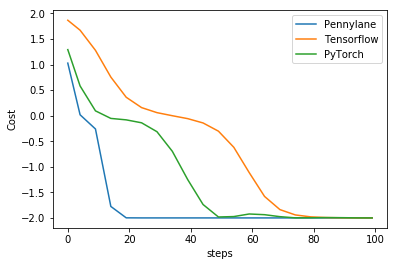

In [23]:
plt.plot(x, cost_gd, label = 'Pennylane')
plt.plot(x, cost_tf, label = 'Tensorflow')
plt.plot(x, cost_pt, label = 'PyTorch')
plt.xlabel("steps")
plt.ylabel("Cost")
plt.legend()
plt.show()

As we use random intialization for all three optimizers, in some runs, you will see one or more of the optimizers getting stuck in a local minima of energy (usually zero energy). Try it! Try running this file multiple times and see how the results change. 

**Do not forget to restart the kernel before rerunning the file! You will find the option in the `Kernel` tab in the top bar.** This makes sure all the variables are cleared up and the optimizers are restarted.  